In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cluster import DBSCAN
from matplotlib import image
from skimage.transform import resize

In [2]:
## INITIALIZE
DownSampleRage     = 2           # The percentage of pixels kept from an original image
fig_name           = 'sample_img.jpg'
half_seed_len      = 1           # half of the length of a squared seed
dist_seed_center   = 6           # distance between the center of consecutive seeds
eps                = 0.6         # PARA eps in DBSCAN
MP                 = 6           # PARA m in DBSCAN
mu                 = 0.00005     # PARA mu in diffusion algorithm
theta              = 1           # PARA theta in diffusion algorithm
eta                = 0.0001      # PARA eta in diffusion algorithm
R_n                = 0.01        # Stoppting criteria of diffusion algorithm
seedsdim           = 4           # Total dimension of seeds
treshvalue         = 205         # Threshold in preprocessing step to get mask image

In [3]:
def AlgIEdge(SeedIm, EdgeIm, X_D, mu, theta, eta, perc):
#      This algorithm is the Edge-weighted harmonic variational optimization model
#      proposed in the paper
#      -inputs:
#       SeedIm       : Seed Image
#       EdgeIm       : Mask Image of the image that $g$ applied onto
#       mu           : multiplier on the constraint V−U=0.
#       lamb         : λ, the Lagrange multiplier associated with the linear constraint V−U=0.
#       eta          : η, fidelity parameter
#      -output :
#       DiffusedIm   : Diffused image

    objval = []
    X_D  = X_D * EdgeIm
    u0   = SeedIm
    u    = u0
    v    = u0
 
    n = u0.shape[0]
    m = u0.shape[1]
    lamb = np.zeros((n,m))
    G0 = np.max(EdgeIm)
    C  = EdgeIm - G0 

    A = np.zeros((n, m))

    for i in range(n):
        for j in range(m):
            A[i,j] = theta + mu- 4*G0 *(np.cos(2*np.pi*(i)/n)+ np.cos(2*np.pi*(j)/m)-2)

    obj= np.sum(EdgeIm * (dxf(u) ** 2 + dyf(u) ** 2) + 0.5 * eta * X_D *(u-SeedIm))
    objval.append(obj)
    
    err = 100
    while err > perc:

        ux = dxf(u)
        uy = dyf(u)
        g = theta * u + 2 * dxb(C * ux) + 2 * dyb(C * uy)+ mu * v +lamb
        u = np.real(np.fft.ifftn(np.fft.fftn(g) / A))
        v = (eta * X_D *u0+mu*u-lamb) /( eta * X_D + mu)
        lamb += mu * (v-u)
        
        obj= np.sum(EdgeIm * (dxf(u) ** 2+ dyf(u) ** 2) + 0.5 * eta * X_D * (u - SeedIm))
        objval.append(obj)
        err = (objval[-2]-objval[-1])/objval[-1]

    return u


In [4]:
def dyf(u):
    v = np.zeros((u.shape[0], u.shape[1]))
    v[:, 1:] = u[:,1:] - u[:,:-1]
    v[:, -1] = u[:,0]  - u[:,-1]
    return v

def dxf(u):
    v = np.zeros((u.shape[0], u.shape[1]))
    v[:-1,:] = u[1:,:]  - u[:-1,:]
    v[-1,:] = u[0, :]  - u[-1, :]
    return v

def dxb(u):
    v = np.zeros((u.shape[0], u.shape[1]))
    v[0,:] = u[0,:] - u[-1,:]
    v[1:,:] = u[1:,:] - u[:-1,:]
    return v

def dyb(u):
    v = np.zeros((u.shape[0], u.shape[1]))
    v[:,0] = u[:,0] - u[:,-1]
    v[:,1:] = u[:,1:] - u[:,:-1]
    return v

In [5]:
# load and display an image with Matplotlib


# load image as pixel array
image = image.imread('sample_img.jpg')

# summarize shape of the pixel array
# print(image.dtype)
# print(image.shape)

# # display the array of pixels as an image
# plt.imshow(image)
# plt.show()

In [6]:
print('Finish reading')

Finish reading


In [7]:
print('start timing')
t = time.time()

start timing


In [8]:
Im = resize(image, (image.shape[0] // 2, image.shape[1] // 2),anti_aliasing=False)

In [9]:
Im = (Im - np.min(Im)) / (np.max(Im) - np.min(Im))

In [10]:
# display the downsampled of pixels as an image
# pyplot.imshow(Im)
# pyplot.show()

In [11]:
n = Im.shape[0]
m = Im.shape[1]
phi = np.zeros((n + 6, m+6))
phi[3:3+n,3:3+m] = Im[:,:,0] ** 2 + Im[:,:,1] ** 2 + Im[:,:,2] ** 2
phi = (phi - np.min(phi)) / (np.max(phi) - np.min(phi))

In [12]:
EdgeMask = np.zeros((n+6, m+6))
EdgeMask[phi > (150 / 255)] = 1
# display the mask image
# pyplot.imshow(EdgeMask)
# pyplot.show()

In [13]:
seed_image         = np.zeros((n+6,m+6,seedsdim))
seed_binary_domain = np.zeros((n+6,m+6))

seed_loc_i = np.arange(half_seed_len+1, n, dist_seed_center) 
seed_loc_j = np.arange(half_seed_len+1, m, dist_seed_center)

In [14]:
# generate seeds in the 1st component
# increse j first then increase i
k = 1  # start with value 1 and every time increase k by 1
for i in seed_loc_i:
    for j in seed_loc_j:
        seed_image[i-half_seed_len:i,j-half_seed_len:j,0] = k
        seed_binary_domain[i-half_seed_len:i,j-half_seed_len:j] = 1
        k += 1

                           

In [15]:
# generate seeds in the 2nd component
# increse i first then decrease j
k = k - 1
for  j in seed_loc_j[::-1]:
    for i in seed_loc_i:
        seed_image[i-half_seed_len:i,j-half_seed_len:j,1]=k
        k -= 1

In [16]:
# generate permutated seeds in 3rd, 4th components

# generate random permutated uniformly distributed values of seeds
# between [1,255] and store them in random_seeds_val.
# each column is a permutation

random_seeds_val = np.zeros((len(seed_loc_i) * len(seed_loc_j),2))
for p in range(2):
    random_seeds_val[:,p] = np.random.permutation(len(seed_loc_i) * len(seed_loc_j))

    
l = 0
for i in seed_loc_i:
    for j in seed_loc_j:
        seed_image[i-half_seed_len:i,j-half_seed_len:j,2] = random_seeds_val[l,0];
        seed_image[i-half_seed_len:i,j-half_seed_len:j,3] = random_seeds_val[l,1];
        l += 1


In [17]:
# Ensure that the values of seeds are located in [1,255] % to distinct the
# seed values from the background value 0
seed_image = seed_image/np.max(seed_image)*255

In [18]:
# display the seed image
# fig, ax = plt.subplots()
# ax.imshow(seed_image/255, extent=[0,1, 0, 1])
# plt.tight_layout()
# plt.show()

In [19]:
print('Finished generating seeds \n')

Finished generating seeds 



In [20]:
#  Edge-weighted harmonic variational optimization model
#  perform diffusion in each dimension 
AlgIdiffIm = np.zeros((n+6, m+6, seedsdim))
for p in range(seedsdim):
    diffused =  AlgIEdge(seed_image[:,:,p],EdgeMask,seed_binary_domain,mu,theta,eta,R_n)
    # normalize the diffused image and only preserve the pixels within
    # the mask image
    diffused = (diffused / np.max(diffused)) * 255 * EdgeMask
    AlgIdiffIm[:,:,p] = diffused

print('Finshied diffusing seeds \n')

Finshied diffusing seeds 



In [21]:
# fig, ax = plt.subplots()
# ax.imshow(AlgIdiffIm[:,:,0]/255)
# plt.tight_layout()
# plt.show()

# fig, ax = plt.subplots()
# ax.imshow(AlgIdiffIm[:,:,1]/255)
# plt.tight_layout()
# plt.show()

# fig, ax = plt.subplots()
# ax.imshow(AlgIdiffIm[:,:,2]/255)
# plt.tight_layout()
# plt.show()

# fig, ax = plt.subplots()
# ax.imshow(AlgIdiffIm[:,:,3]/255)
# plt.tight_layout()
# plt.show()

In [22]:
# Apply DBSCAN to diffused image
# Vectorize the diffused pixels in all objects.
D = []
for p in range(seedsdim):
    DD =  AlgIdiffIm[:,:,p]
    D.append(DD[DD >0])
    # Each row in D is associated with a pixel in the mask in multiple
    # dimension
    # Each column of D is associated with all pixels in the mask in one
    # dimension
D = np.array(D).T

In [23]:
# Apply a high dimensional density based clustering algorithm to D with
# predeterminated paramters eps(\epsilon) and MP(MinPoints)
clustering = DBSCAN(eps=eps, min_samples=MP).fit(D)
IDX = clustering.labels_
# Number of clusters in labels, ignoring noise if present.
NumOfClusters = len(set(IDX)) - (1 if -1 in IDX else 0)
n_noise_ = list(IDX).count(-1)
print('Finished Clustering')
elapsed = time.time() - t
print('CPU time: ', elapsed, 'seconds')

Finished Clustering
CPU time:  1.5409953594207764 seconds


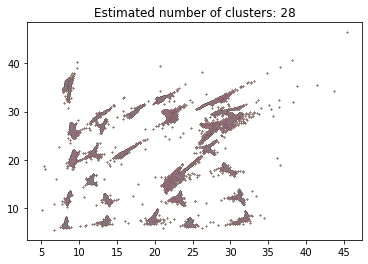

In [24]:
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

# Black removed and is used for noise instead.
labels = IDX
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = D[class_member_mask & core_samples_mask]
    plt.plot(D[:, 0], D[:, 1], 'o', markerfacecolor=tuple(col),
             markersize=0.1)

    xy = D[class_member_mask & ~core_samples_mask]
    plt.plot(D[:, 0], D[:, 1], 'o', markerfacecolor=tuple(col),
             markersize=0.1)

plt.title('Estimated number of clusters: %d' % NumOfClusters)
plt.show()